# Analisis Datos Holallar

## Shopify

In [63]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

def read_latest_csv(directory_path):
    try:
        # Obtener la lista de archivos en el directorio
        files = [
            os.path.join(directory_path, file)
            for file in os.listdir(directory_path)
            if file.endswith('.csv')
        ]

        if not files:
            print("No se encontraron archivos CSV en la ruta especificada.")
            return None

        # Encontrar el archivo más reciente por fecha de modificación
        latest_file = max(files, key=os.path.getmtime)

        # Leer el archivo CSV usando pandas
        data = pd.read_csv(latest_file)
        print(f"Archivo más reciente: {latest_file}")

        return data
    except Exception as e:
        print(f"Ocurrió un error: {e}")
        return None

# Ruta de la carpeta compartida
directory_path_shopify = r"C:\Users\nicol\OneDrive\Documentos\VSCLocal\Data\Holallar\Shopify"

# Ruta de los productos
directory_path_products = pd.read_excel(r"C:\Users\nicol\OneDrive\Documentos\VSCLocal\Data\Holallar\Tablas_auxiliares\Productos.xlsx")

# Leer el archivo más reciente
latest_data_shopify = read_latest_csv(directory_path_shopify)

if latest_data_shopify is not None:
    print(latest_data_shopify.shape)

Archivo más reciente: C:\Users\nicol\OneDrive\Documentos\VSCLocal\Data\Holallar\Shopify\Shopify_23-01-2025_1.csv
(5827, 79)


In [64]:
if latest_data_shopify is not None:
    print("Rótulos del DataFrame:")
    col_list = list(latest_data_shopify.columns)
    chunk_size = 10  # Número de columnas por línea
    for i in range(0, len(col_list), chunk_size):
        print(", ".join(col_list[i:i + chunk_size]))

Rótulos del DataFrame:
Name, Email, Financial Status, Paid at, Fulfillment Status, Fulfilled at, Accepts Marketing, Currency, Subtotal, Shipping
Taxes, Total, Discount Code, Discount Amount, Shipping Method, Created at, Lineitem quantity, Lineitem name, Lineitem price, Lineitem compare at price
Lineitem sku, Lineitem requires shipping, Lineitem taxable, Lineitem fulfillment status, Billing Name, Billing Street, Billing Address1, Billing Address2, Billing Company, Billing City
Billing Zip, Billing Province, Billing Country, Billing Phone, Shipping Name, Shipping Street, Shipping Address1, Shipping Address2, Shipping Company, Shipping City
Shipping Zip, Shipping Province, Shipping Country, Shipping Phone, Notes, Note Attributes, Cancelled at, Payment Method, Payment Reference, Refunded Amount
Vendor, Outstanding Balance, Employee, Location, Device ID, Id, Tags, Risk Level, Source, Lineitem discount
Tax 1 Name, Tax 1 Value, Tax 2 Name, Tax 2 Value, Tax 3 Name, Tax 3 Value, Tax 4 Name, Tax

In [65]:
latest_data_shopify['Created at'].dtypes

dtype('O')

In [66]:
display(latest_data_shopify.head(3))

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Tax 5 Value,Phone,Receipt Number,Duties,Billing Province Name,Shipping Province Name,Payment ID,Payment Terms Name,Next Payment Due At,Payment References
0,#9307,jcpelgar@gmail.com,pending,NaN,unfulfilled,NaN,no,EUR,49.99,0.0,...,NaN,3.464618e+10,NaN,NaN,Asturias,Asturias,#9307.1,NaN,NaN,#9307.1
1,#9306,carihuela2021@gmail.com,pending,NaN,unfulfilled,NaN,no,EUR,29.99,0.0,...,NaN,3.462099e+10,NaN,NaN,Ciudad Real,Ciudad Real,#9306.1,NaN,NaN,#9306.1
2,#9305,misupema@hotmail.com,pending,NaN,unfulfilled,NaN,no,EUR,29.99,0.0,...,NaN,3.463989e+10,NaN,NaN,Asturias,Asturias,#9305.1,NaN,NaN,#9305.1


In [69]:
def transform_dataframe(df, directory_path_products):
    try:
        # Cambiar tipos de columnas
        df = df.astype({
            "Subtotal": "float64",
            "Total": "float64",
            "Discount Amount": "float64",
            "Lineitem quantity": "int64"
        })

        # Seleccionar columnas necesarias
        required_columns = [
            "Name", "Financial Status", "Fulfillment Status", "Total", "Paid at", 
            "Created at", "Fulfilled at", "Cancelled at", "Lineitem quantity", 
            "Lineitem name", "Payment Method", "Shipping Zip", "Shipping City", 
            "Shipping Province"
        ]
        df = df[required_columns]

        # Reemplazar caracteres en columnas específicas
        df["Lineitem name"] = df["Lineitem name"].str.replace("®", "", regex=False)

        # Lista de las columnas con fechas
        date_columns = ["Created at", "Paid at", "Fulfilled at", "Cancelled at"]

        # Convertir las columnas a datetime y formatear a fecha corta
        for col in date_columns:
            # Convertir a formato datetime, manejando errores y valores NaN
            df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S %z', errors='coerce')
            
            # Convertir a formato corto (dd/mm/yyyy), preservando NaT para valores NaN
            df[col] = df[col].dt.strftime('%d/%m/%Y')

        # Crear columna "Estado Detallado"
        estado_mapping = lambda row: (
            "Pendiente de envío" if row["Financial Status"] in ["paid", "pending"] and row["Fulfillment Status"] == "unfulfilled" else
            "Enviado" if row["Financial Status"] == "pending" and row["Fulfillment Status"] == "fulfilled" else
            "Entregado" if row["Financial Status"] == "paid" and row["Fulfillment Status"] == "fulfilled" else
            "Anulado" if row["Financial Status"] in ["voided", "refunded"] and row["Fulfillment Status"] == "unfulfilled" else
            "Devuelto" if row["Financial Status"] in ["voided", "refunded"] and row["Fulfillment Status"] == "fulfilled" else
            "Anulado" if row["Financial Status"] == "voided" and row["Fulfillment Status"] == "restocked" else
            "Otro"
        )
        df["Estado Detallado"] = df.apply(estado_mapping, axis=1)

        # Definir el límite de tiempo para la condición de 'publicidad'
        time_limit_str = '2025-01-21'
        time_limit = time_limit_str.dt.strftime('%d/%m/%Y')

        df['publicidad'] = df['Created at'].apply(
            lambda x: 'Meta Ads' if pd.notnull(x) and x.date() < time_limit else 'Tik Tok Ads')
        
        # Convertir fechas a formato tz-naive
        for col in date_columns:
            df[col] = df[col].dt.tz_localize(None)

        # Crear columnas con formato corto (dd/mm/aaaa)
        for col in date_columns:
            df[f"{col}_short"] = df[col].dt.strftime('%d/%m/%Y')

        # Modificar 'Payment Method'
        payment_method_mapping = lambda x: (
            'COD' if x in ['Cash on Delivery (COD)', 'Manual'] else
            'Prepayment' if x in ['Shopify Payments', 'PayPal Express Checkout'] else
            'Otro'
        )
        df['Payment Method'] = df['Payment Method'].apply(payment_method_mapping)

        # Unir tabla de Shopify con la tabla de productos
        merged_df = df.merge(
            directory_path_products,
            left_on="Lineitem name",
            right_on="Producto",
            how="left"
        )

        # Crear columna 'Identificador costo'
        merged_df['Identificador costo'] = (
            merged_df['Etiqueta'] + '_' + 
            merged_df['Created at'].dt.strftime('%Y') + '_' + 
            merged_df['Created at'].dt.strftime('%m')
        )

        # Reordenar columnas
        merged_df = merged_df[[
            "Name", "Estado Detallado", "Financial Status", "Fulfillment Status", "Total", 
            "Created at", "Fulfilled at", "Paid at", "Cancelled at", "Lineitem name", 
            "Etiqueta", "Tipo", "Lineitem quantity", "Factor", "Payment Method", 
            "publicidad", "Identificador costo", "Shipping Zip", "Shipping City", 
            "Shipping Province"
        ]]

        # Quitar duplicados basados en la columna 'Etiqueta'
        etiquetas_to_check = ["Mascarilla lifting", "Guantes térmicos", "Lumiluxa"]
        filtered_df = merged_df[merged_df['Etiqueta'].isin(etiquetas_to_check)]
        other_df = merged_df[~merged_df['Etiqueta'].isin(etiquetas_to_check)]

        grouped_df = (filtered_df.groupby('Name', as_index=False)
                      .agg({col: 'first' if col != 'Lineitem quantity' else 'sum' for col in filtered_df.columns}))

        merged_df = pd.concat([grouped_df, other_df], ignore_index=True)

        # Calcular 'Cantidad Ajustada'
        merged_df['Cantidad Ajustada'] = merged_df['Lineitem quantity'] * merged_df['Factor']

        # Eliminar filas con 'Factor' igual a 0
        merged_df = merged_df[merged_df['Factor'] != 0]

        # Convertir 'Factor' y 'Cantidad Ajustada' a enteros
        merged_df['Factor'] = merged_df['Factor'].fillna(0).astype(int)
        merged_df['Cantidad Ajustada'] = merged_df['Cantidad Ajustada'].fillna(0).astype(int)

        return merged_df

    except Exception as e:
        print(f"Error al transformar el DataFrame: {e}")
        return None

# Aplicación de la función
if latest_data_shopify is not None:
    transformed_data = transform_dataframe(latest_data_shopify, directory_path_products)
    if transformed_data is not None:
        display(transformed_data.shape)


Error al transformar el DataFrame: Can only use .dt accessor with datetimelike values


C:\Users\nicol\AppData\Local\Temp\ipykernel_23332\4070426750.py:29: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S %z', errors='coerce')


In [68]:
def process_and_sort_dates(df, columns_to_convert=None, sort_by_column="Created at"):
    """
    Procesa un DataFrame para convertir columnas de fecha a formato normalizado y lo ordena por una columna específica.

    Parámetros:
        df (pd.DataFrame): DataFrame a procesar.
        columns_to_convert (list, opcional): Lista de columnas a convertir a formato de fecha. Si es None, usa columnas predeterminadas.
        sort_by_column (str): Columna por la que se ordenará el DataFrame (por defecto "Created at").

    Retorna:
        pd.DataFrame: DataFrame procesado y ordenado.
    """
    # Usar columnas predeterminadas si no se especifican
    if columns_to_convert is None:
        columns_to_convert = ["Paid at", "Created at", "Fulfilled at", "Cancelled at"]

    # Verificar que las columnas existen en el DataFrame
    columns_to_convert = [col for col in columns_to_convert if col in df.columns]

    for column in columns_to_convert:
        # Convertir a datetime manejando zonas horarias y errores
        df[column] = pd.to_datetime(df[column], errors="coerce", utc=True)

        # Normalizar las fechas eliminando horas, minutos y segundos
        df[column] = df[column].dt.date

    # Ordenar el DataFrame por la columna especificada si existe
    if sort_by_column in df.columns:
        df = df.sort_values(by=sort_by_column)

    return df

# Aplicar la función al DataFrame transformado
processed_data = process_and_sort_dates(transformed_data)

# Mostrar el tamaño del DataFrame procesado
processed_data.shape


AttributeError: 'NoneType' object has no attribute 'columns'

In [52]:
output_path = r"C:\Users\nicol\OneDrive\Documentos\VSCLocal\Data\Holallar\Tablas_auxiliares\shopify_orders.csv"
process_and_sort_dates(transformed_data).to_csv(output_path, index=False)

In [ ]:
process_and_sort_dates(transformed_data).shape

(4887, 21)

In [56]:
grouped = process_and_sort_dates(transformed_data).groupby(["Created at", "Estado Detallado"])["Name"].count().unstack(fill_value=0)
grouped.shape

(0, 0)

In [ ]:
def plot_grouped_orders_by_status(df, date_column="Created at", status_column="Estado Detallado", name_column="Name"):
    """
    Crea un gráfico de barras apiladas que muestra los pedidos agrupados por fecha y estado detallado.

    Parámetros:
        df (pd.DataFrame): DataFrame que contiene los datos de pedidos.
        date_column (str): Nombre de la columna con las fechas (por defecto "Created at").
        status_column (str): Nombre de la columna con los estados detallados (por defecto "Estado Detallado").
        name_column (str): Nombre de la columna con los identificadores de los pedidos (por defecto "Name").

    Retorna:
        None: Muestra el gráfico directamente.
    """
    # Ordenar el DataFrame por la columna de fecha
    df = df.sort_values(by=date_column)

    # Agrupar por fecha y estado detallado, contando los pedidos por estado
    grouped = df.groupby([date_column, status_column])[name_column].count().unstack(fill_value=0)

    # Asignar colores a cada estado en el orden deseado
    estado_colores = {
        "Pendiente de envío": "#FFD700",  # Amarillo
        "Anulado": "#FFA500",           # Naranja
        "Enviado": "#6699CC",           # Azul
        "Entregado": "#66CC66",         # Verde brillante
        "Devuelto": "#FF6666",          # Rojo claro
        "Otro": "#CCCCCC"               # Gris
    }

    # Reordenar las columnas del DataFrame en el orden deseado
    grouped = grouped[list(estado_colores.keys())[::-1]]  # Invertir el orden de las columnas

    # Crear el gráfico con los colores personalizados
    ax = grouped.plot(
        kind="bar",
        stacked=True,
        figsize=(20, 8),
        color=[estado_colores[col] for col in grouped.columns]
    )

    # Agregar etiquetas encima de cada barra apilada (solo si el valor es mayor a 0)
    for container in ax.containers:
        labels = [f"{int(val)}" if val > 0 else "" for val in container.datavalues]
        ax.bar_label(container, labels=labels, label_type="center", fontsize=8, padding=2)

    # Calcular y agregar los totales encima de cada barra
    totales = grouped.sum(axis=1)
    for i, total in enumerate(totales):
        ax.text(i, total + 2, f"{int(total)}", ha="center", fontsize=8, fontweight="bold")

    # Personalizar el gráfico
    plt.title("Pedidos agrupados por día y estado detallado", fontsize=16)
    plt.xlabel("Fecha", fontsize=12)
    plt.ylabel("Número de pedidos", fontsize=12)
    plt.legend(title="Estado Detallado", loc="upper left", fontsize=10)
    plt.xticks(rotation=90, fontsize=10)  # Ajustar rotación y tamaño de texto en el eje X
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

plot_grouped_orders_by_status(processed_data)

KeyError: "None of [Index(['Otro', 'Devuelto', 'Entregado', 'Enviado', 'Anulado',\n       'Pendiente de envío'],\n      dtype='object', name='Estado Detallado')] are in the [columns]"

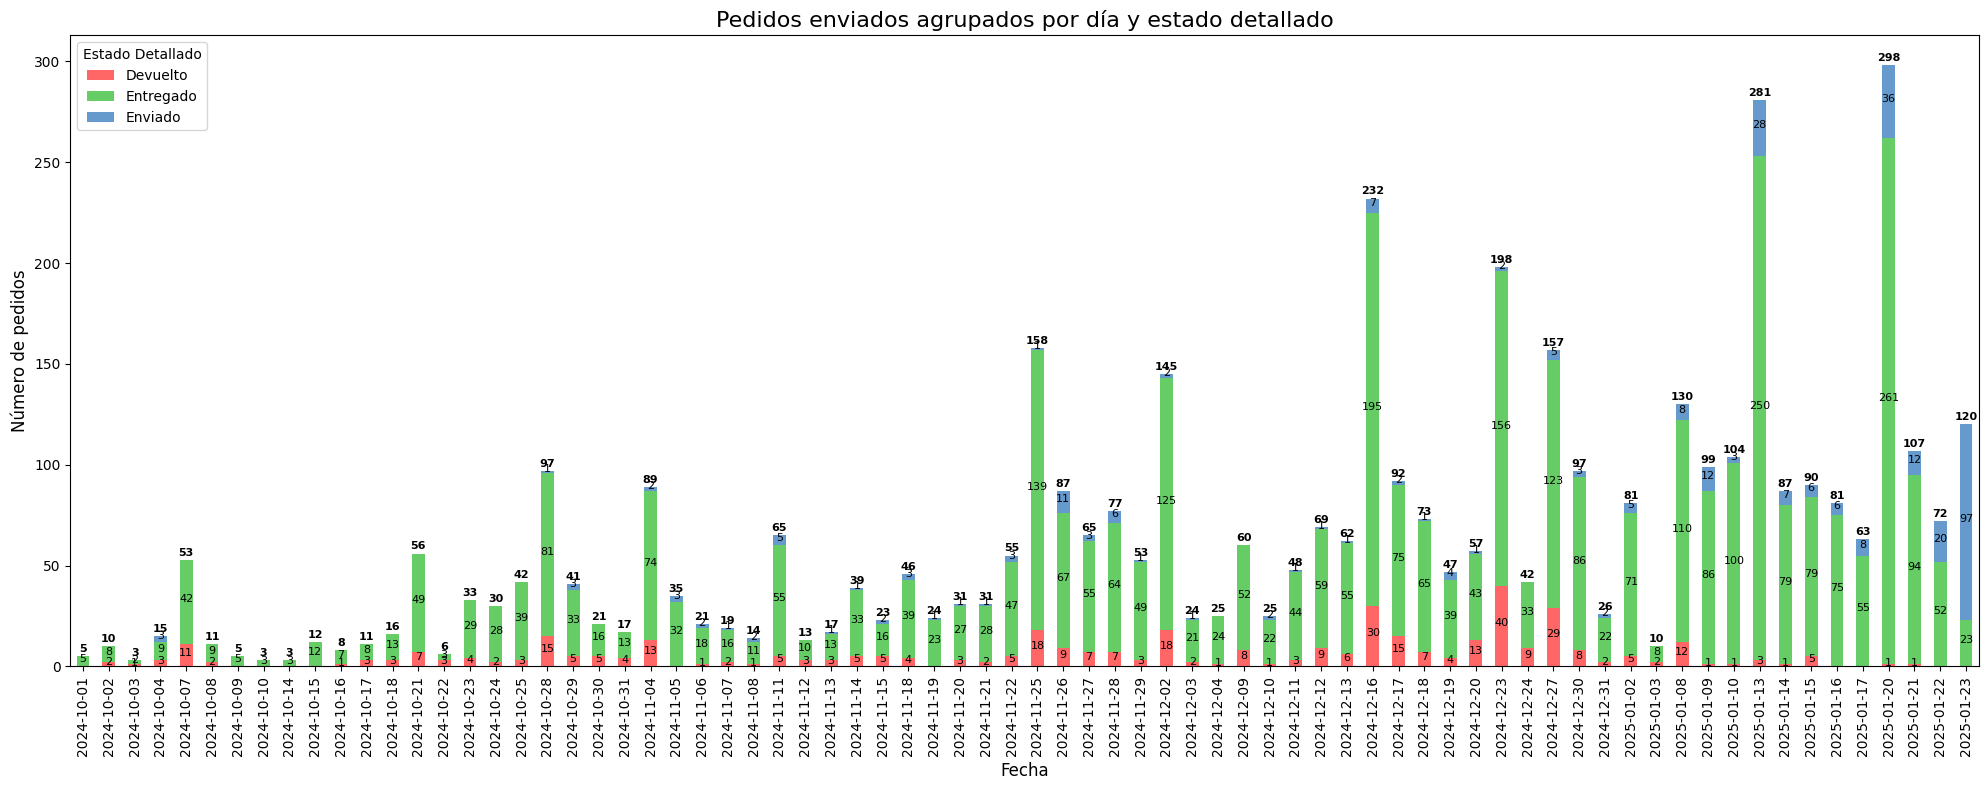

In [36]:
def plot_fulfilled_orders_by_status(df, date_column="Fulfilled at", status_column="Estado Detallado", name_column="Name"):
    """
    Crea un gráfico de barras apiladas que muestra los pedidos cumplidos agrupados por fecha y estado detallado.

    Parámetros:
        df (pd.DataFrame): DataFrame que contiene los datos de pedidos.
        date_column (str): Nombre de la columna con las fechas (por defecto "Fulfilled at").
        status_column (str): Nombre de la columna con los estados detallados (por defecto "Estado Detallado").
        name_column (str): Nombre de la columna con los identificadores de los pedidos (por defecto "Name").

    Retorna:
        None: Muestra el gráfico directamente.
    """
    # Ordenar el DataFrame por la columna de fecha
    df = df.sort_values(by=date_column)

    # Agrupar por fecha y estado detallado, contando los pedidos por estado
    grouped = df.groupby([date_column, status_column])[name_column].count().unstack(fill_value=0)

    # Asignar colores a cada estado en el orden deseado
    estado_colores = {
        "Enviado": "#6699CC",           # Azul
        "Entregado": "#66CC66",         # Verde brillante
        "Devuelto": "#FF6666"           # Rojo claro
    }

    # Reordenar las columnas del DataFrame en el orden deseado
    grouped = grouped[list(estado_colores.keys())[::-1]]  # Invertir el orden de las columnas

    # Crear el gráfico con los colores personalizados
    ax = grouped.plot(
        kind="bar",
        stacked=True,
        figsize=(20, 8),
        color=[estado_colores[col] for col in grouped.columns]
    )

    # Agregar etiquetas encima de cada barra apilada (solo si el valor es mayor a 0)
    for container in ax.containers:
        labels = [f"{int(val)}" if val > 0 else "" for val in container.datavalues]
        ax.bar_label(container, labels=labels, label_type="center", fontsize=8, padding=2)

    # Calcular y agregar los totales encima de cada barra
    totales = grouped.sum(axis=1)
    for i, total in enumerate(totales):
        ax.text(i, total + 2, f"{int(total)}", ha="center", fontsize=8, fontweight="bold")

    # Personalizar el gráfico
    plt.title("Pedidos enviados agrupados por día y estado detallado", fontsize=16)
    plt.xlabel("Fecha", fontsize=12)
    plt.ylabel("Número de pedidos", fontsize=12)
    plt.legend(title="Estado Detallado", loc="upper left", fontsize=10)
    plt.xticks(rotation=90, fontsize=10)  # Ajustar rotación y tamaño de texto en el eje X
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

plot_fulfilled_orders_by_status(transformed_data)

In [9]:
import plotly.express as px
import pandas as pd

def plot_fulfilled_orders_by_status_plotly(df, date_column="Fulfilled at", status_column="Estado Detallado", name_column="Name"):
    """
    Crea un gráfico de barras apiladas que muestra los pedidos cumplidos agrupados por fecha y estado detallado.

    Parámetros:
        df (pd.DataFrame): DataFrame que contiene los datos de pedidos.
        date_column (str): Nombre de la columna con las fechas (por defecto "Fulfilled at").
        status_column (str): Nombre de la columna con los estados detallados (por defecto "Estado Detallado").
        name_column (str): Nombre de la columna con los identificadores de los pedidos (por defecto "Name").

    Retorna:
        None: Muestra el gráfico directamente.
    """
    # Ordenar el DataFrame por la columna de fecha
    df = df.sort_values(by=date_column)

    # Agrupar por fecha y estado detallado, contando los pedidos por estado
    grouped = df.groupby([date_column, status_column])[name_column].count().reset_index(name="Cantidad")

    # Crear el gráfico interactivo con Plotly
    fig = px.bar(
        grouped,
        x=date_column,
        y="Cantidad",
        color=status_column,
        title="Pedidos enviados agrupados por día y estado detallado",
        color_discrete_map={
            "Enviado": "#6699CC",           # Azul
            "Entregado": "#66CC66",         # Verde brillante
            "Devuelto": "#FF6666"           # Rojo claro
        },
        labels={"Cantidad": "Número de pedidos", date_column: "Fecha", status_column: "Estado Detallado"},
        barmode="stack",
    )

    # Asegurar que las fechas se vean correctamente en el eje X
    fig.update_xaxes(type="category")

    # Agregar texto total encima de cada barra
    grouped_totals = grouped.groupby(date_column)["Cantidad"].sum().reset_index()
    for i, row in grouped_totals.iterrows():
        fig.add_annotation(
            x=row[date_column],
            y=row["Cantidad"],
            text=f"{int(row['Cantidad'])}",
            showarrow=False,
            yshift=10,
            font=dict(size=12, color="black", family="Arial"),
        )

    # Configurar diseño del gráfico
    fig.update_layout(
        xaxis_title="Fecha",
        yaxis_title="Número de pedidos",
        legend_title="Estado Detallado",
        title_font_size=16,
        xaxis_tickangle=90,
        xaxis=dict(categoryorder="category ascending"),
    )

    # Mostrar el gráfico
    fig.show()

# Llama a la función con tu DataFrame
plot_fulfilled_orders_by_status_plotly(transformed_data)


In [ ]:

def generate_grouped_tables(df):
    """
    Genera dos tablas agrupadas: una con valores absolutos y otra con valores relativos.
    Agrupa por Estado Detallado en las columnas y por Año de Created at, Mes de Created at, Payment Method,
    y Etiqueta en las filas. Las columnas se ordenan como Pendiente de envío, Enviado, Entregado, Anulado y Devuelto.
    Además, añade columnas Total, %Entrega y %Envío.

    Parámetros:
        df (pd.DataFrame): DataFrame que contiene los datos.

    Retorna:
        tuple: (tabla_absoluta, tabla_relativa)
    """
    # Asegurarse de que las columnas necesarias existen
    required_columns = ["Created at", "Estado Detallado", "Payment Method", "Etiqueta"]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"La columna requerida '{col}' no existe en el DataFrame.")

    # Convertir la columna "Created at" a datetime si no lo está
    df["Created at"] = pd.to_datetime(df["Created at"], errors="coerce")

    # Crear columnas de Año y Mes
    df["Año"] = df["Created at"].dt.year
    df["Mes"] = df["Created at"].dt.month

    # Agrupar por Año, Mes, Payment Method, Etiqueta y crear columnas por Estado Detallado
    grouped = df.groupby(["Año", "Mes", "Payment Method", "Etiqueta", "Estado Detallado"]).size().unstack(fill_value=0)

    # Ordenar las columnas en el orden deseado
    estado_orden = ["Pendiente de envío", "Enviado", "Entregado", "Anulado", "Devuelto"]
    grouped = grouped.reindex(columns=estado_orden, fill_value=0)

    # Calcular la columna Total
    grouped["Total"] = grouped.sum(axis=1)

    # Calcular %Entrega y %Envío
    grouped["%Entrega"] = 1 - grouped["Devuelto"] / (grouped["Total"] - grouped["Anulado"])
    grouped["%Entrega"] = grouped["%Entrega"].fillna(0) * 100  # Manejar divisiones por cero

    grouped["%Envío"] = 1 - grouped["Anulado"] / grouped["Total"]
    grouped["%Envío"] = grouped["%Envío"].fillna(0) * 100  # Manejar divisiones por cero

    # Crear tabla de valores absolutos
    tabla_absoluta = grouped

    # Crear tabla de valores relativos
    tabla_relativa = grouped.iloc[:, :-3].div(grouped["Total"], axis=0).fillna(0) * 100
    tabla_relativa["Total"] = grouped["Total"]
    tabla_relativa["%Entrega"] = grouped["%Entrega"]
    tabla_relativa["%Envío"] = grouped["%Envío"]

    return tabla_absoluta, tabla_relativa

tabla_absoluta, tabla_relativa = generate_grouped_tables(transformed_data)
display(tabla_absoluta)
display(tabla_relativa)


Estado Detallado                            Pendiente de envío  Enviado  \
Año  Mes Payment Method Etiqueta                                          
2024 10  COD            Barra luz led                        0        1   
                        Corrector capilar                    0        2   
                        Cortador vegetal                     0        0   
                        Elevador de altura                   0        0   
                        Expansor zapato                      0        2   
...                                                        ...      ...   
2025 1   Prepayment     Dispensador aceite                   1        0   
                        Expansor zapato                      0        0   
                        Guantes térmicos                     0        0   
                        Lumiluxa                             1        0   
                        Naturlight                           0        0   

Estado Detallado                            Entregado  Anulado  Devuelto  \
Año  Mes Payment Method Etiqueta                                           
2024 10  COD            Barra luz led              61       26         8   
                        Corrector capilar          21        7        10   
                        Cortador vegetal            5        0         1   
                        Elevador de altura         82        7        15   
                        Expansor zapato           164       14        24   
...                                               ...      ...       ...   
2025 1   Prepayment     Dispensador aceite         38        0         0   
                        Expansor zapato             1        0         0   
                        Guantes térmicos            1        0         0   
                        Lumiluxa                  106        1         0   
                        Naturlight                  4        0         0   

Estado Detallado                            Total    %Entrega      %Envío  
Año  Mes Payment Method Etiqueta                                           
2024 10  COD            Barra luz led          96   88.571429   72.916667  
                        Corrector capilar      40   69.696970   82.500000  
                        Cortador vegetal        6   83.333333  100.000000  
                        Elevador de altura    104   84.536082   93.269231  
                        Expansor zapato       204   87.368421   93.137255  
...                                           ...         ...         ...  
2025 1   Prepayment     Dispensador aceite     39  100.000000  100.000000  
                        Expansor zapato         1  100.000000  100.000000  
                        Guantes térmicos        1  100.000000  100.000000  
                        Lumiluxa              108  100.000000   99.074074  
                        Naturlight              4  100.000000  100.000000  

[61 rows x 8 columns]

Estado Detallado                            Pendiente de envío   Enviado  \
Año  Mes Payment Method Etiqueta                                           
2024 10  COD            Barra luz led                 0.000000  1.041667   
                        Corrector capilar             0.000000  5.000000   
                        Cortador vegetal              0.000000  0.000000   
                        Elevador de altura            0.000000  0.000000   
                        Expansor zapato               0.000000  0.980392   
...                                                        ...       ...   
2025 1   Prepayment     Dispensador aceite            2.564103  0.000000   
                        Expansor zapato               0.000000  0.000000   
                        Guantes térmicos              0.000000  0.000000   
                        Lumiluxa                      0.925926  0.000000   
                        Naturlight                    0.000000  0.000000   

Estado Detallado                             Entregado    Anulado   Devuelto  \
Año  Mes Payment Method Etiqueta                                               
2024 10  COD            Barra luz led        63.541667  27.083333   8.333333   
                        Corrector capilar    52.500000  17.500000  25.000000   
                        Cortador vegetal     83.333333   0.000000  16.666667   
                        Elevador de altura   78.846154   6.730769  14.423077   
                        Expansor zapato      80.392157   6.862745  11.764706   
...                                                ...        ...        ...   
2025 1   Prepayment     Dispensador aceite   97.435897   0.000000   0.000000   
                        Expansor zapato     100.000000   0.000000   0.000000   
                        Guantes térmicos    100.000000   0.000000   0.000000   
                        Lumiluxa             98.148148   0.925926   0.000000   
                        Naturlight          100.000000   0.000000   0.000000   

Estado Detallado                            Total    %Entrega      %Envío  
Año  Mes Payment Method Etiqueta                                           
2024 10  COD            Barra luz led          96   88.571429   72.916667  
                        Corrector capilar      40   69.696970   82.500000  
                        Cortador vegetal        6   83.333333  100.000000  
                        Elevador de altura    104   84.536082   93.269231  
                        Expansor zapato       204   87.368421   93.137255  
...                                           ...         ...         ...  
2025 1   Prepayment     Dispensador aceite     39  100.000000  100.000000  
                        Expansor zapato         1  100.000000  100.000000  
                        Guantes térmicos        1  100.000000  100.000000  
                        Lumiluxa              108  100.000000   99.074074  
                        Naturlight              4  100.000000  100.000000  

[61 rows x 8 columns]

In [ ]:
import plotly.express as px
import pandas as pd

def plot_orders_by_month_and_product_plotly(df):
    """
    Genera gráficos por Año y Mes que muestran los pedidos agrupados por productos (Etiqueta) dentro de cada gráfico.
    Cada barra se separa por color en función del Estado Detallado.

    Parámetros:
        df (pd.DataFrame): DataFrame que contiene los datos procesados.

    Retorna:
        None: Muestra los gráficos directamente.
    """
    # Asegurarse de que las columnas necesarias existen
    required_columns = ["Año", "Mes", "Etiqueta", "Estado Detallado"]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"La columna requerida '{col}' no existe en el DataFrame.")

    # Iterar por cada año y mes únicos en los datos
    for año in sorted(df["Año"].unique()):
        for mes in sorted(df["Mes"].unique()):
            # Filtrar los datos para el año y mes actuales
            data_mes = df[(df["Año"] == año) & (df["Mes"] == mes)]

            if not data_mes.empty:
                # Agrupar los datos
                grouped = data_mes.groupby(["Etiqueta", "Estado Detallado"]).size().reset_index(name="Cantidad")

                # Crear el gráfico interactivo con Plotly
                fig = px.bar(
                    grouped,
                    x="Etiqueta",
                    y="Cantidad",
                    color="Estado Detallado",
                    title=f"Pedidos en {año}-{mes:02d} por producto (Etiqueta)",
                    color_discrete_map={
                        "Pendiente de envío": "#FFD700",  # Amarillo
                        "Enviado": "#6699CC",           # Azul
                        "Entregado": "#66CC66",         # Verde brillante
                        "Anulado": "#FFA500",           # Naranja
                        "Devuelto": "#FF6666",          # Rojo claro
                        "Otro": "#CCCCCC"               # Gris
                    },
                    labels={"Cantidad": "Número de pedidos", "Etiqueta": "Productos"},
                    barmode="stack",
                )

                # Agregar texto total encima de cada barra
                grouped_totals = grouped.groupby("Etiqueta")["Cantidad"].sum().reset_index()
                for i, row in grouped_totals.iterrows():
                    fig.add_annotation(
                        x=row["Etiqueta"],
                        y=row["Cantidad"],
                        text=f"Total: {int(row['Cantidad'])}",
                        showarrow=False,
                        yshift=10,
                        font=dict(size=12, color="black", family="Arial"),
                    )

                # Configurar diseño del gráfico
                fig.update_layout(
                    xaxis_title="Productos (Etiqueta)",
                    yaxis_title="Número de pedidos",
                    legend_title="Estado Detallado",
                    title_font_size=16,
                    xaxis_tickangle=-45,
                )

                # Mostrar el gráfico
                fig.show()

# Llama a la función con tu DataFrame
plot_orders_by_month_and_product_plotly(transformed_data)


## Envía

In [12]:
def read_latest_csv(directory_path):
    try:
        # Obtener la lista de archivos en el directorio
        files = [
            os.path.join(directory_path, file)
            for file in os.listdir(directory_path)
            if file.endswith('.csv')
        ]

        if not files:
            print("No se encontraron archivos CSV en la ruta especificada.")
            return None

        # Encontrar el archivo más reciente por fecha de modificación
        latest_file = max(files, key=os.path.getmtime)

        # Leer el archivo CSV usando pandas
        data = pd.read_csv(latest_file)
        print(f"Archivo más reciente: {latest_file}")

        return data
    except Exception as e:
        print(f"Ocurrió un error: {e}")
        return None

# Ruta de la carpeta compartida
directory_path_envia = r"C:\Users\nicol\OneDrive\Documentos\VSCLocal\Data\Holallar\Envia\25_01_2025_Envia.csv"

# Leer el archivo más reciente
latest_data_envia = read_latest_csv(directory_path_envia)

if latest_data_envia is not None:
    print(latest_data_envia.shape)

Archivo más reciente: C:\Users\PC-5\Documents\Nicolas\Ecommerce\Ventas\DATOS_HOLALLAR\Envia.com\Envia_24-01-2025.csv
(4700, 94)


In [13]:
# Mantén solo los primeros 5 caracteres de 'sender_name' y valores entre comillas en 'tracking_number'
latest_data_envia["sender_name"] = latest_data_envia["sender_name"].str[:5]
latest_data_envia["tracking_number"] = latest_data_envia["tracking_number"].str.extract(r'"([^"]+)"')
latest_data_envia["shipped_at"] = latest_data_envia["shipped_at"].str.extract(r'"([^"]+)"')
latest_data_envia["delivered_at"] = latest_data_envia["delivered_at"].str.extract(r'"([^"]+)"')

# Lista de columnas que deseas conservar
columns_to_keep = ["sender_name", "tracking_number", "utc_created_at", "shipped_at", "delivered_at","cash_on_delivery_cost", "cash_on_delivery_amount", "cost", "total", "grand_total",
    "service", "service_description", "carrier_description", "consignee_name","consignee_company_name", "consignee_email", "consignee_phone", "consignee_street",
    "consignee_number", "consignee_interior_number", "consignee_district","consignee_city", "consignee_state", "consignee_country", "consignee_postalcode",
    "consignee_identification_number", "consignee_references", "status","status_parent_id", "class_name"]

# Filtrar el DataFrame
filtered_df = latest_data_envia[columns_to_keep]

# Mostrar el resultado
display(filtered_df)


,sender_name,tracking_number,utc_created_at,shipped_at,delivered_at,cash_on_delivery_cost,cash_on_delivery_amount,cost,total,grand_total,...,consignee_district,consignee_city,consignee_state,consignee_country,consignee_postalcode,consignee_identification_number,consignee_references,status,status_parent_id,class_name
0,#9341,0048150008189700022776,2025-01-23 14:43:25,2025-01-23 18:27:46,NaN,2.42,29.99,3.87,3.87,3.91,...,NaN,Moanao,PO,ES,36950,NaN,por la tarde,Shipped,6,primary
1,#9340,0048150008189700013565,2025-01-23 14:39:40,2025-01-23 18:27:27,NaN,2.42,29.99,3.75,3.75,3.78,...,NaN,Girona,GI,ES,17004,NaN,NaN,Shipped,6,primary
2,#9339,0048150008189700005627,2025-01-23 14:33:58,2025-01-23 18:27:26,NaN,2.72,49.99,4.31,4.31,4.35,...,NaN,Santiago de Compostela,C,ES,15701,NaN,por la tarde,Shipped,6,primary
3,#9338,0048150008189700051143,2025-01-23 14:18:30,2025-01-23 18:27:24,NaN,2.42,29.99,3.87,3.87,3.91,...,NaN,Linares,J,ES,23700,NaN,por la tarde,Shipped,6,primary
4,#9100,0048150008189700041826,2025-01-23 14:16:02,NaN,NaN,2.42,29.99,3.86,3.86,3.90,...,NaN,Belandia/ orduna,BI,ES,48460,NaN,llamar antes,Canceled,5,danger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4695,Carme,PQ8M1C071168362W,2024-10-01 11:35:52,NaN,NaN,0.00,0.00,3.99,3.99,4.10,...,NaN,Badalona,B,ES,8918,NaN,NaN,Created,1,secondary
4696,Elosu,0048150008189700002469,2024-10-01 11:33:45,2024-10-01 17:40:12,2024-10-02 09:30:48,0.00,0.00,4.04,4.04,4.08,...,NaN,Zaragoza,Z,ES,50007,NaN,#4339,Delivered,3,success
4697,#4436,0048150008189700020804,2024-10-01 11:17:00,2024-10-04 03:11:25,2024-10-04 11:28:06,2.42,39.99,4.04,4.04,4.08,...,NaN,Limpias,S,ES,39820,NaN,ENTREGAR EN LA FARMACIA,Delivered,3,success
4698,#4435,0048150008189700011247,2024-10-01 11:16:37,2024-10-01 17:41:00,2024-10-02 11:13:18,2.42,39.99,4.06,4.06,4.10,...,NaN,Granada,GR,ES,18004,NaN,ENTREGAR POR LA TARDE,Delivered,3,success


In [14]:
output_path = r"C:\Users\nicol\OneDrive\Documentos\VSCLocal\Data\Holallar\Tablas_auxiliares\envia_orders.csv"
filtered_df.to_csv(output_path, index=False)